# Figure 2A

## MD

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_distance_normalized_frequency(csv_file,
                                              bin_width=0.375,
                                              x_min=2.0,
                                              x_max=22.0,
                                              title='Distance Frequency',
                                              color='#6DA5ED',
                                              edgecolor='#2866A3',
                                              output_filename=None):
    """
    Plot a normalized histogram for a single CSV file of distances.
    Also prints the mean and median of the distances.

    Args:
        csv_file (str): Path to the CSV file. Must contain a 'Distance' column.
        bin_width (float): Bin width for histogram. Default is 0.375 Å.
        x_min (float): Minimum x-axis value. Default is 2.0 Å.
        x_max (float): Maximum x-axis value. Default is 22.0 Å.
        title (str): Title of the plot.
        color (str): Fill color of the bars.
        edgecolor (str): Edge color of the bars.
        output_filename (str, optional): Output filename (with or without .png).
    """
    # Load data
    df = pd.read_csv(csv_file)
    distances = df['Distance']

    # Calculate statistics
    mean_val = distances.mean()
    median_val = distances.median()

    print(f"Mean distance: {mean_val:.2f} Å")
    print(f"Median distance: {median_val:.2f} Å")

    # Create bins
    bin_edges = np.arange(x_min, x_max + bin_width, bin_width)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Histogram
    freq, _ = np.histogram(distances, bins=bin_edges)
    norm_freq = freq / len(distances)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.bar(bin_centers, norm_freq, width=bin_width,
            color=color, edgecolor=edgecolor, linewidth=2, alpha=0.6)

    # Decorations
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Distance (Å)', fontsize=16)
    plt.ylabel('Probability', fontsize=16)
    plt.xticks([5, 10, 15, 20], fontsize=24)
    plt.yticks(fontsize=24)
    plt.axvline(x=5.86, color='red', linestyle='--', linewidth=3)
    plt.axvline(x=9.97, color='black', linestyle='--', linewidth=3)
    #plt.ylim(0, 0.6) #used for MD distance distribution
    plt.ylim(0, 1.0) 
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Save figure
    if output_filename is None:
        base_dir = os.path.dirname(csv_file)
        grandparent = os.path.basename(os.path.dirname(base_dir))
        target = os.path.basename(base_dir)
        output_filename = f"normalized_histogram_{grandparent}_{target}.png"
    elif not output_filename.endswith(".png"):
        output_filename += ".png"

    output_path = os.path.join(os.path.dirname(csv_file), output_filename)
    plt.savefig(output_path, dpi=300)
    plt.show()


Mean distance: 5.93 Å
Median distance: 5.86 Å


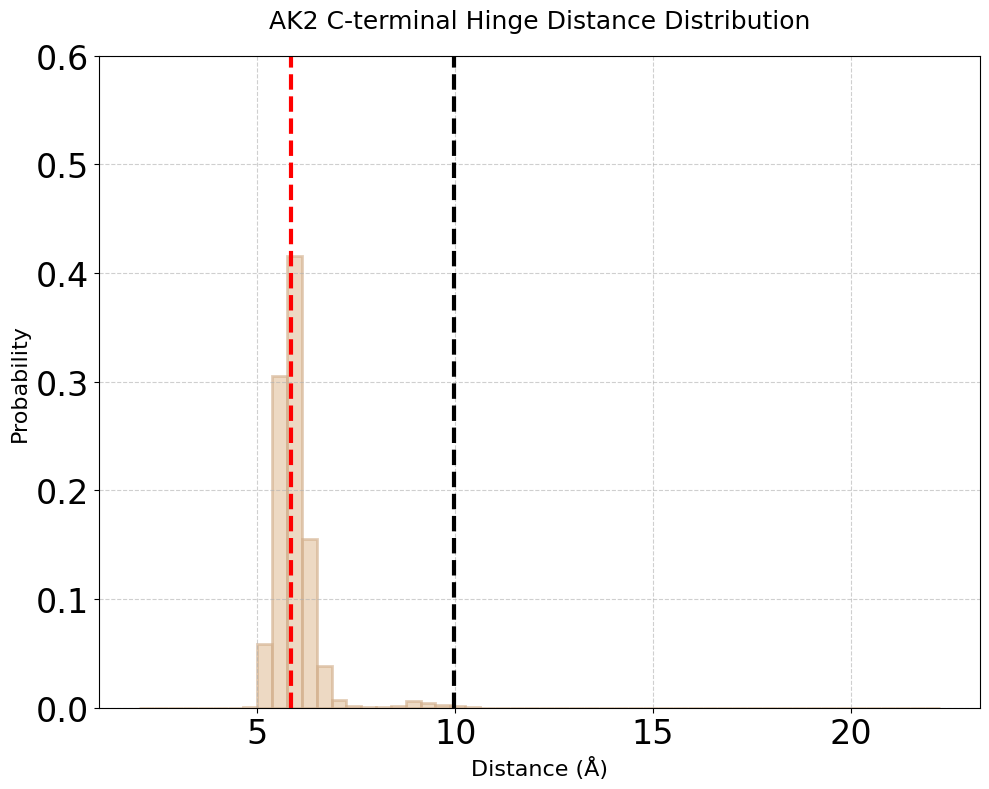

In [109]:
plot_distance_normalized_frequency(
    csv_file="/Users/busra/Desktop/distogram/FEBS/MD/230_233_apo_merged.dist",
    title="AK2 C-terminal Hinge Distance Distribution",
    color="#E1C09C",
    edgecolor="#D1AD89",
    output_filename="230_233_apo_merged"
)

Mean distance: 10.16 Å
Median distance: 9.97 Å


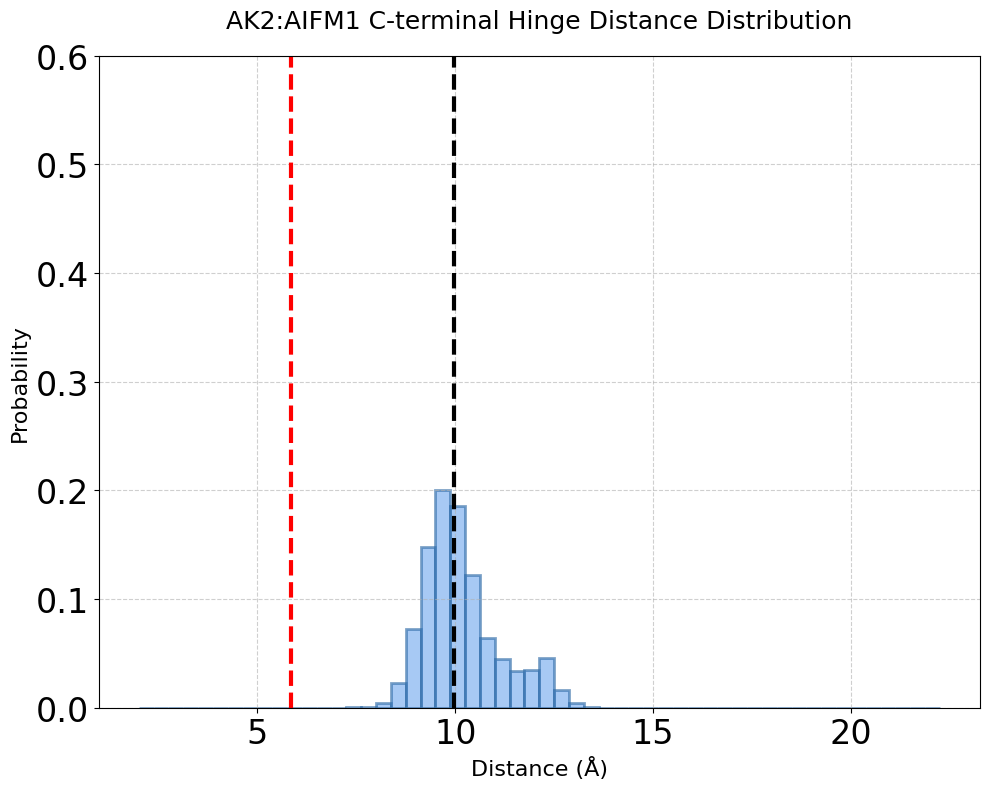

In [110]:
plot_distance_normalized_frequency(
    csv_file="/Users/busra/Desktop/distogram/FEBS/MD/230_233_complex_merged.dist",
    title="AK2:AIFM1 C-terminal Hinge Distance Distribution",
    color="#6DA5ED",
    edgecolor="#2866A3",
    output_filename="230_233_complex_merged"
)

# Figure 2B

## Distograms

In [103]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pickle
from matplotlib.ticker import FuncFormatter

def plot_all_distograms_in_directory(directory_path, res_i=230, res_j=233, temperature=1.0, title=None):
    """
    Plot distograms for residue pair (res_i, res_j) from all .npz or .pkl files in a directory.

    Args:
        directory_path (str): Path to the folder containing distogram .npz or .pkl files.
        res_i (int): Residue index i (1-based biological indexing).
        res_j (int): Residue index j (1-based biological indexing).
        temperature (float): Temperature scaling for logits -> probability conversion.
        title (str, optional): Custom title for the plot. Defaults to a standard title.
    """
    file_paths = sorted(glob(os.path.join(directory_path, "*.npz")) + 
                        glob(os.path.join(directory_path, "*.pkl")) +
                        glob(os.path.join(directory_path, "*.pickle")))

    if not file_paths:
        print(f"No .npz or .pkl files found in {directory_path}")
        return

    bin_edges = np.arange(2.0, 22.1875 + 0.3125, 0.3125)[:65]
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    plt.figure(figsize=(10, 8))
    colors = plt.cm.Spectral(np.linspace(0, 1, len(file_paths)))

    for i, file_path in enumerate(file_paths):
        logits = None

        if file_path.endswith(".npz"):
            data = np.load(file_path)
            logits = data.get('logits', None)
            if logits is None:
                dgram = data.get('distogram', None)
                if isinstance(dgram, dict) and 'logits' in dgram:
                    logits = dgram['logits']
                elif isinstance(dgram, np.ndarray):
                    logits = dgram

        elif file_path.endswith(".pickle"):
            with open(file_path, "rb") as f:
                data = pickle.load(f)
                if 'logits' in data:
                    logits = data['logits']
                elif 'distogram' in data:
                    dgram = data['distogram']
                    if isinstance(dgram, dict) and 'logits' in dgram:
                        logits = dgram['logits']
                    elif isinstance(dgram, np.ndarray):
                        logits = dgram

        if logits is None:
            print(f"No logits/distogram found in {file_path}")
            continue

        # Convert logits to probability
        scaled_logits = logits / temperature
        exp_logits = np.exp(scaled_logits - np.max(scaled_logits, axis=-1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

        # Extract residue pair (0-based index)
        try:
            probs_res = probs[res_i - 1, res_j - 1, :]
        except IndexError:
            print(f"Index error in {file_path}: shape={logits.shape}, requested=({res_i},{res_j})")
            continue

        label = os.path.basename(file_path).replace(".npz", "").replace(".pkl", "")
        plt.plot(bin_centers, probs_res, label=label, color=colors[i], linewidth=2)

    if title is None:
        title = f"Distogram - Residue {res_i} vs {res_j}"
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel("Distance (Å)", fontsize=16)
    plt.ylabel("Probability", fontsize=16)
    plt.ylim(0, 0.6)
    plt.xticks([5, 10, 15, 20], fontsize=24)
    plt.yticks(fontsize=24)
    plt.axvline(x=5.86, color='red', linestyle='--', linewidth=3)
    plt.axvline(x=9.97, color='black', linestyle='--', linewidth=3)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}")) 
    plt.tight_layout()
    base_dir = os.path.dirname(directory_path)  # .../FEBS/af3/ak2
    grandparent = os.path.basename(os.path.dirname(base_dir))  # af3
    target = os.path.basename(base_dir)  # ak2
    #plt.legend(fontsize=14, loc="best")
    filename = f"distogram_distribution_{grandparent}_{target}_res{res_i}_{res_j}.png"
    output_path = os.path.join(os.path.dirname(base_dir), filename)

    plt.savefig(output_path, dpi=300)
    plt.show()


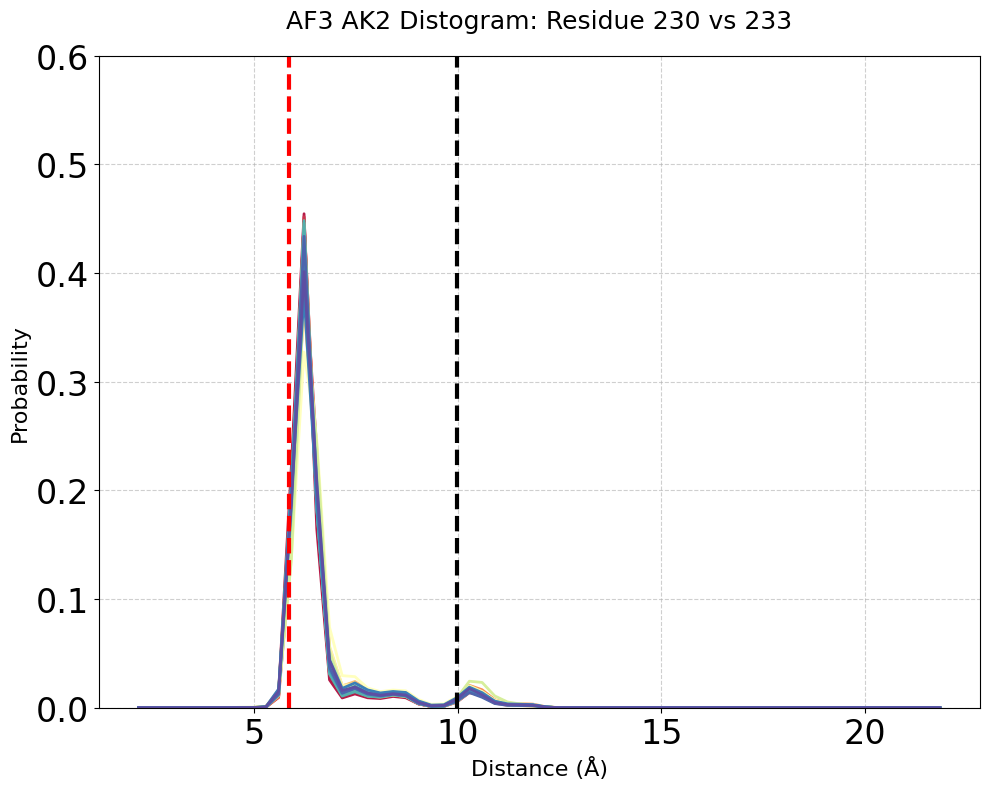

In [58]:
res_i = 230
res_j = 233
plot_all_distograms_in_directory(
    "/Users/busra/Desktop/distogram/FEBS/af3-seed25/ak2/distograms",
    res_i=res_i,
    res_j=res_j,
    title=f"AF3 AK2 Distogram: Residue {res_i} vs {res_j}"
)

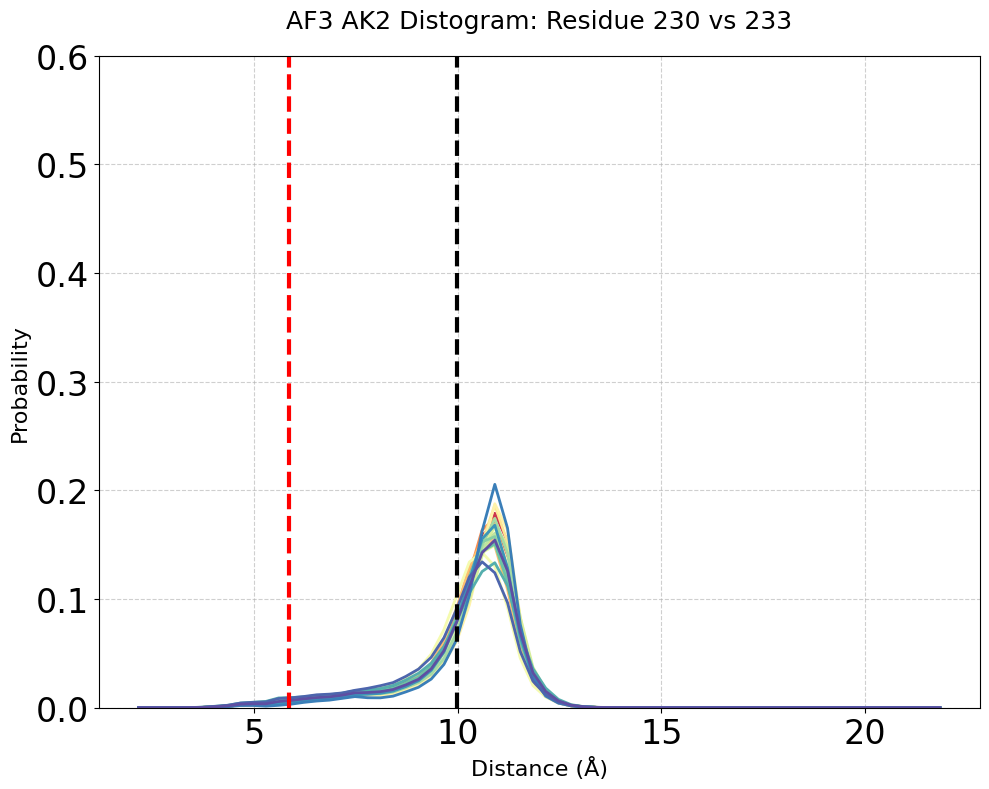

In [59]:
res_i = 230
res_j = 233
plot_all_distograms_in_directory(
    "/Users/busra/Desktop/distogram/FEBS/af3-seed25/ak2-aifm1/distograms",
    res_i=res_i,
    res_j=res_j,
    title=f"AF3 AK2 Distogram: Residue {res_i} vs {res_j}"
)

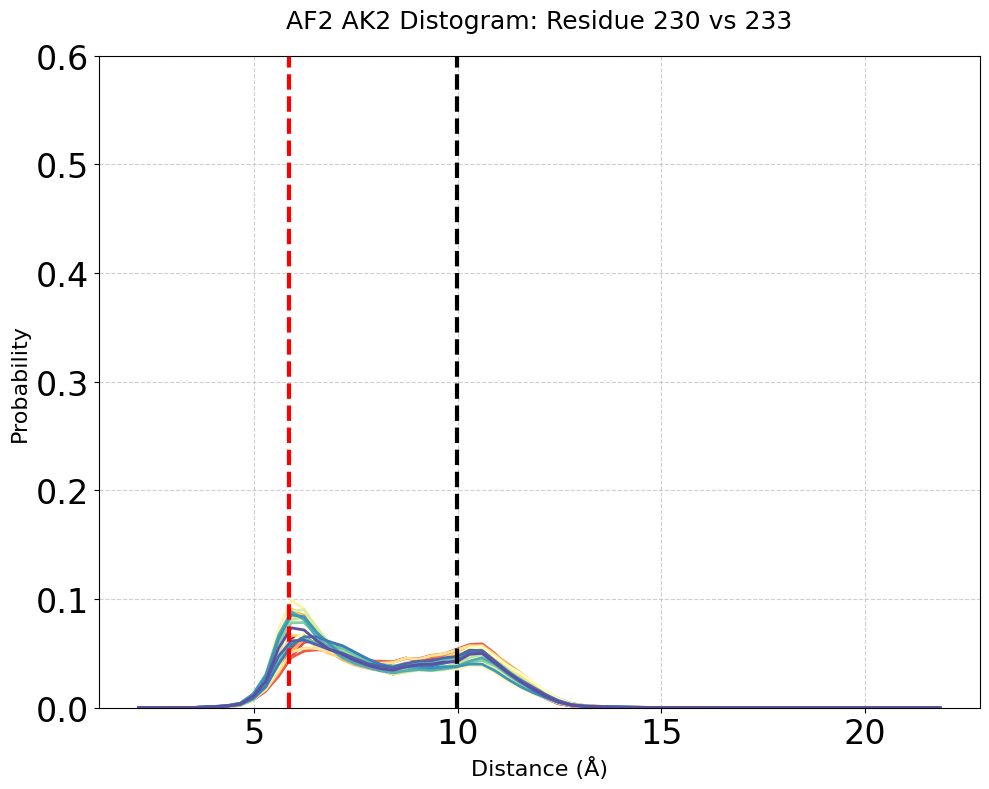

In [104]:
res_i = 230
res_j = 233
plot_all_distograms_in_directory(
    "/Users/busra/Desktop/distogram/FEBS/af2-seed5/ak2/distograms",
    res_i=res_i,
    res_j=res_j,
    title=f"AF2 AK2 Distogram: Residue {res_i} vs {res_j}"
)

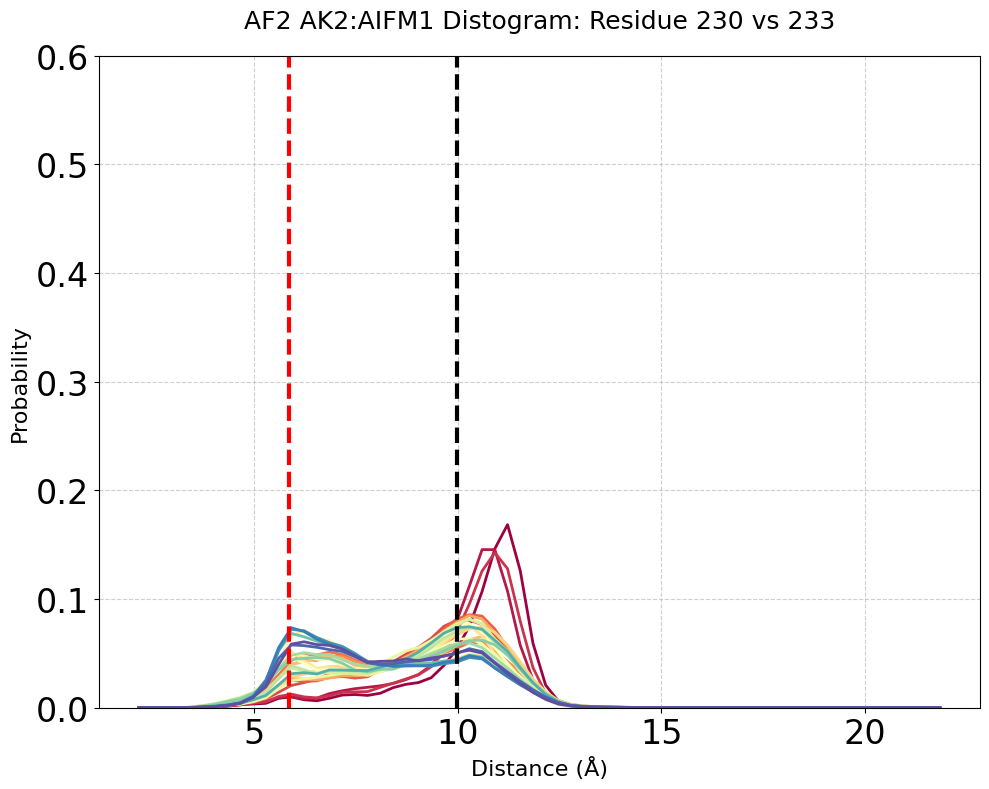

In [61]:
res_i = 230
res_j = 233
plot_all_distograms_in_directory(
    "/Users/busra/Desktop/distogram/FEBS/af2-seed5/ak2-aifm1/distograms",
    res_i=res_i,
    res_j=res_j,
    title=f"AF2 AK2:AIFM1 Distogram: Residue {res_i} vs {res_j}"
)

# Figure 2C

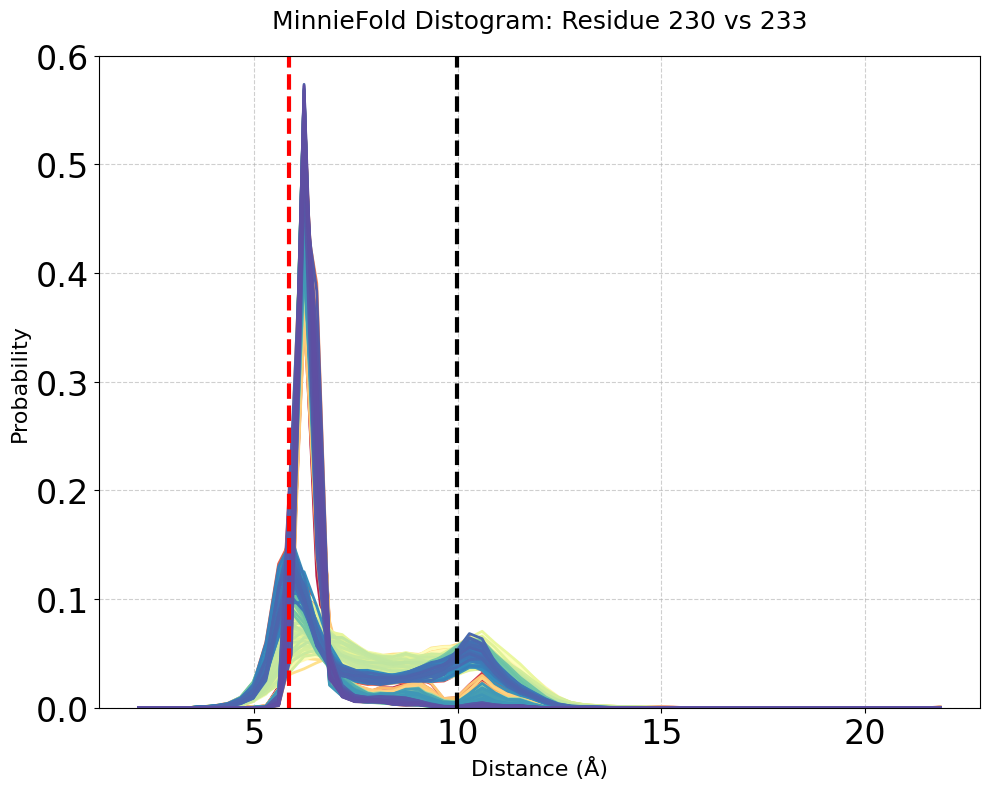

In [62]:
res_i = 230
res_j = 233
plot_all_distograms_in_directory(
    "/Users/busra/Desktop/distogram/FEBS/minniefold/ak2/distograms",
    res_i=res_i,
    res_j=res_j,
    title=f"MinnieFold Distogram: Residue {res_i} vs {res_j}"
)

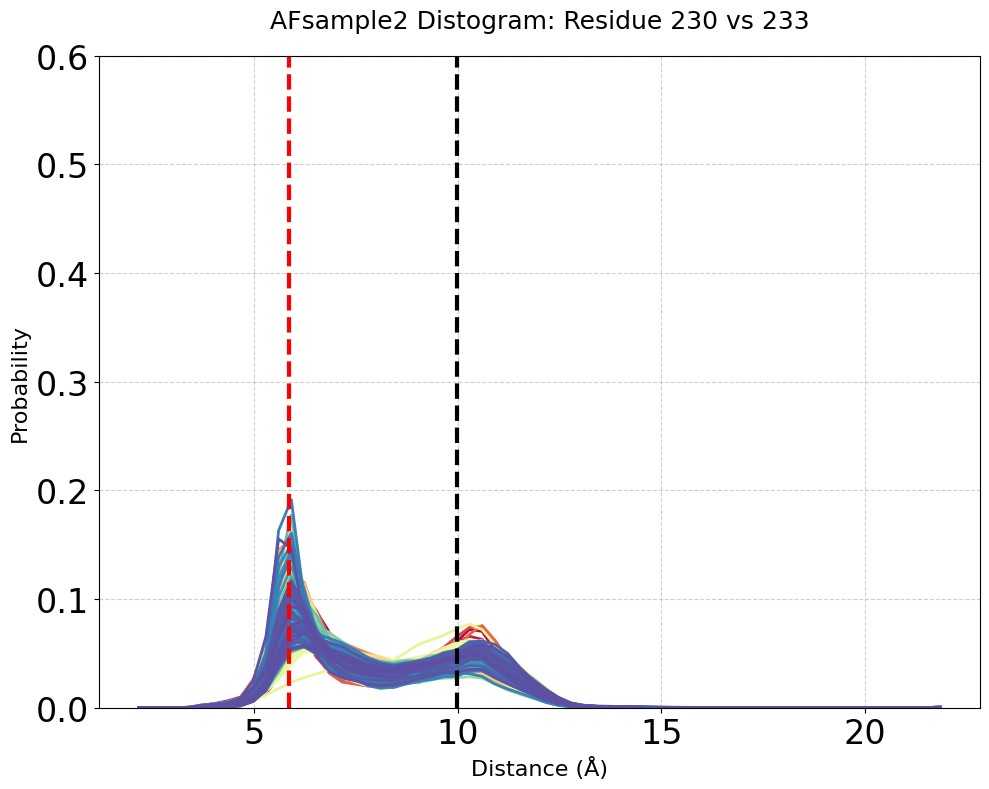

In [95]:
res_i = 230
res_j = 233
plot_all_distograms_in_directory(
    "/Users/busra/Desktop/distogram/FEBS/afsample2/ak2/distograms",
    res_i=res_i,
    res_j=res_j,
    title=f"AFsample2 Distogram: Residue {res_i} vs {res_j}"
)

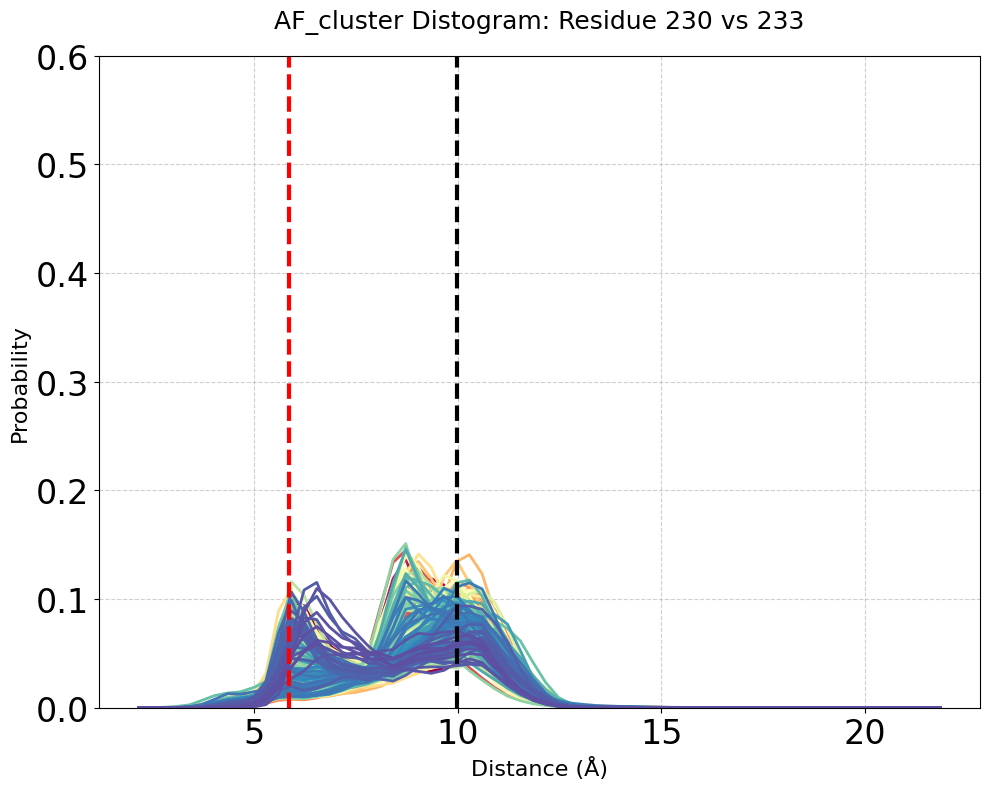

In [93]:
res_i = 230
res_j = 233
plot_all_distograms_in_directory(
    "/Users/busra/Desktop/distogram/FEBS/afcluster/ak2/distograms",
    res_i=res_i,
    res_j=res_j,
    title=f"AF_cluster Distogram: Residue {res_i} vs {res_j}"
)

# Figure S1

In [100]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pickle
from collections import defaultdict
import re

# Scenario-to-recycle mapping
scenario_to_recycles = {
    1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3,
    7: 9, 9: 9, 11: 9, 13: 9, 15: 9, 17: 9, 21: 9, 23: 9,
    8: 21, 10: 21, 12: 21, 14: 21, 16: 21, 18: 21, 22: 21, 24: 21,
    19: 3, 20: 3
}

# Colors per version
version_colors = {
    "ptm": "#AA60C8",  # purple
    "v1": "#4FBDBA",   # teal
    "v2": "#E88A1A",   # orange
    "v3": "#B1BD5D"    # olive
}

# Custom subplot titles
version_titles = {
    "ptm": "AF2-ptm",
    "v1": "AF-v2.1",
    "v2": "AF-v2.2",
    "v3": "AF-v2.3"
}

def extract_recycle_from_scenario(filename):
    """Extract scenario number from filename and map to recycle count."""
    match = re.search(r'scenario(\d+)', filename)
    if match:
        scenario_num = int(match.group(1))
        return scenario_to_recycles.get(scenario_num)
    return None

def plot_all_distograms_by_version(
    directory_path, res_i=230, res_j=233, temperature=1.0,
    title=None, output_path="distogram_versions_plot.png"
):
    """
    Plot 2×2 grid of distogram probability profiles by AlphaFold version.

    Args:
        directory_path (str): Path to .npz or .pickle distogram files.
        res_i, res_j (int): Residue indices (1-based).
        temperature (float): Logit scaling.
        title (str): Figure title.
        output_path (str): File path to save the figure.
    """
    file_paths = sorted(glob(os.path.join(directory_path, "*.npz")) +
                        glob(os.path.join(directory_path, "*.pickle")))

    if not file_paths:
        print(f"No distogram files found in {directory_path}")
        return

    # Categorize files by version
    categorized_files = defaultdict(list)
    for path in file_paths:
        if "_ptm_" in path:
            categorized_files["ptm"].append(path)
        elif "_v1_" in path:
            categorized_files["v1"].append(path)
        elif "_v2_" in path:
            categorized_files["v2"].append(path)
        elif "_v3_" in path:
            categorized_files["v3"].append(path)

    versions = ["ptm", "v1", "v2", "v3"]
    fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
    axes = axes.flatten()

    bin_edges = np.arange(2.0, 22.1875 + 0.3125, 0.3125)[:65]
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    for i, version in enumerate(versions):
        ax = axes[i]
        files = categorized_files.get(version, [])
        if not files:
            ax.set_title(f"{version_titles.get(version, version.upper())}\n(No data)", fontsize=16)
            continue

        color = version_colors.get(version, "#999999")

        for file_path in files:
            logits = None

            if file_path.endswith(".npz"):
                data = np.load(file_path)
                logits = data.get('logits') or data.get('distogram')
                if isinstance(logits, dict):
                    logits = logits.get('logits')
            elif file_path.endswith(".pickle"):
                with open(file_path, "rb") as f:
                    data = pickle.load(f)
                    logits = data.get('logits')
                    if logits is None and 'distogram' in data:
                        dgram = data['distogram']
                        logits = dgram.get('logits') if isinstance(dgram, dict) else dgram

            if logits is None:
                print(f"No logits/distogram found in {file_path}")
                continue

            # Softmax to convert logits to probabilities
            scaled_logits = logits / temperature
            exp_logits = np.exp(scaled_logits - np.max(scaled_logits, axis=-1, keepdims=True))
            probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

            try:
                probs_res = probs[res_i - 1, res_j - 1, :]
            except IndexError:
                print(f"Index error in {file_path}: shape={logits.shape}, requested=({res_i},{res_j})")
                continue

            ax.plot(bin_centers, probs_res, color=color, alpha=0.8)
            # Add vertical dashed reference lines
            ax.axvline(x=5.86, color='red', linestyle='--', linewidth=3)
            ax.axvline(x=9.97, color='black', linestyle='--', linewidth=3)



        # Formatting
        ax.set_title(version_titles.get(version, version.upper()), fontsize=24, pad=30)
        ax.set_ylabel("Probability", fontsize=16)
        ax.set_xticks([5, 10, 15, 20])
        ax.set_yticks(np.linspace(0, 1.0, 6))
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylim(0, 0.6)

    for ax in axes:
        ax.set_xlabel("Distance (Å)", fontsize=16)
        ax.label_outer()

    if title:
        fig.suptitle(title, fontsize=20)


    # Add version legend
    handles = [plt.Line2D([0], [0], color=color, lw=3, label=version_titles.get(ver, ver.upper()))
               for ver, color in version_colors.items()]
    #fig.legend(handles=handles, loc="upper right", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.92] if title else None)
    plt.savefig(output_path, dpi=300)
    plt.show()


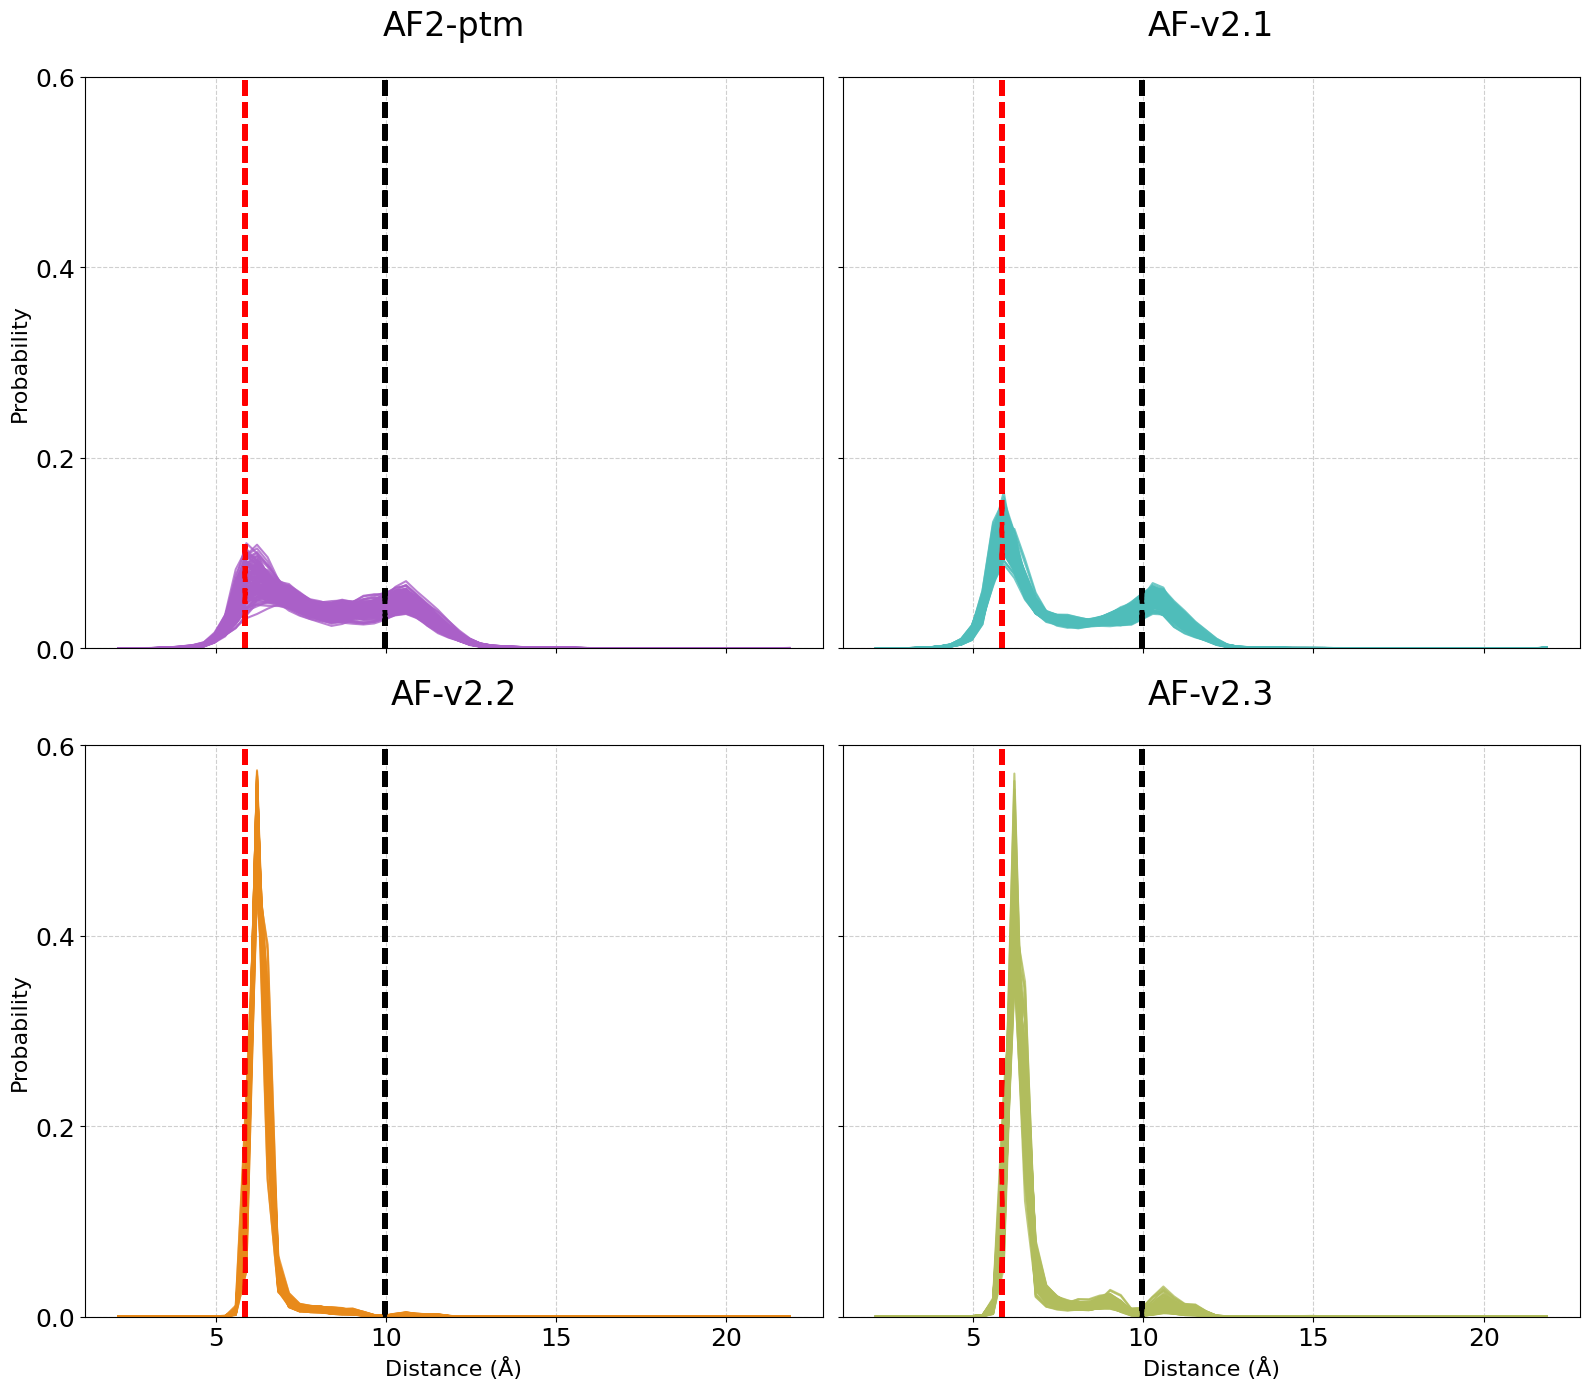

In [101]:
res_i = 230
res_j = 233
plot_all_distograms_by_version(
    "/Users/busra/Desktop/distogram/FEBS/minniefold/ak2/distograms",
    res_i=res_i,
    res_j=res_j,
    output_path="/Users/busra/Desktop/distogram/FEBS/minniefold/ak2/distogram_versions_plot.png"
)

# Figure S2

Mean distance: 6.26 Å
Median distance: 6.22 Å


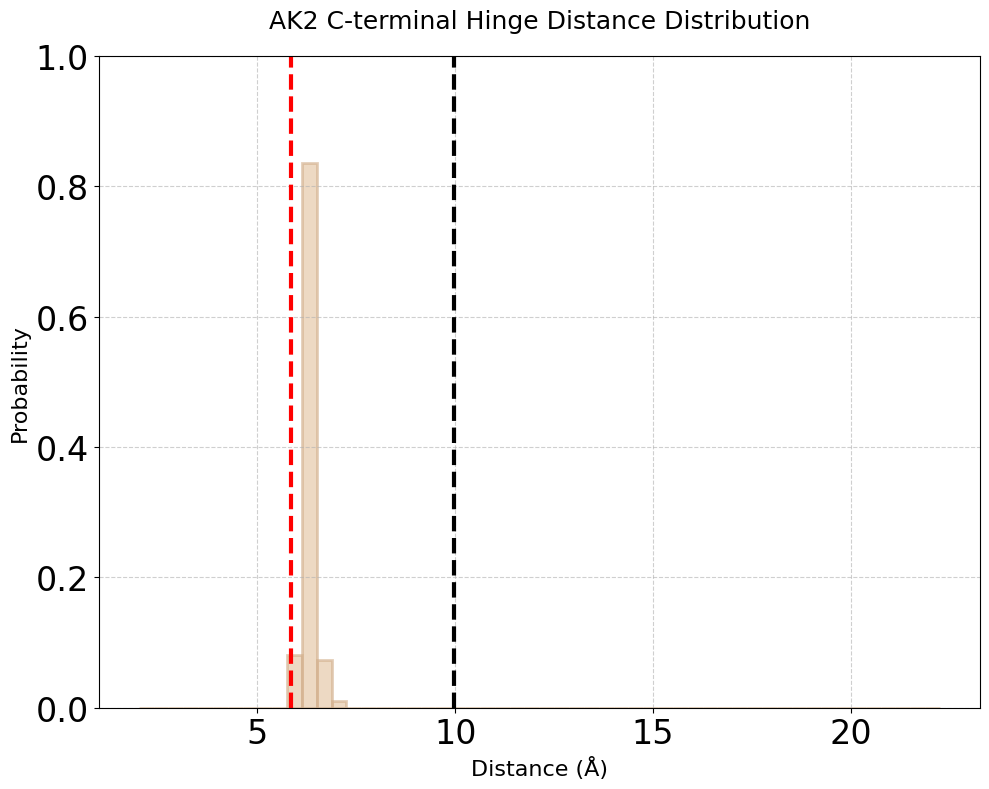

In [116]:
plot_distance_normalized_frequency(
    csv_file="/Users/busra/Documents/GitHub/AF-based_distograms/distogram_data/minniefold/ak2/measurements.csv",
    title="AK2 C-terminal Hinge Distance Distribution",
    color="#E1C09C",
    edgecolor="#D1AD89",
    output_filename="MinnieFold-distance"
)

Mean distance: 6.28 Å
Median distance: 6.28 Å


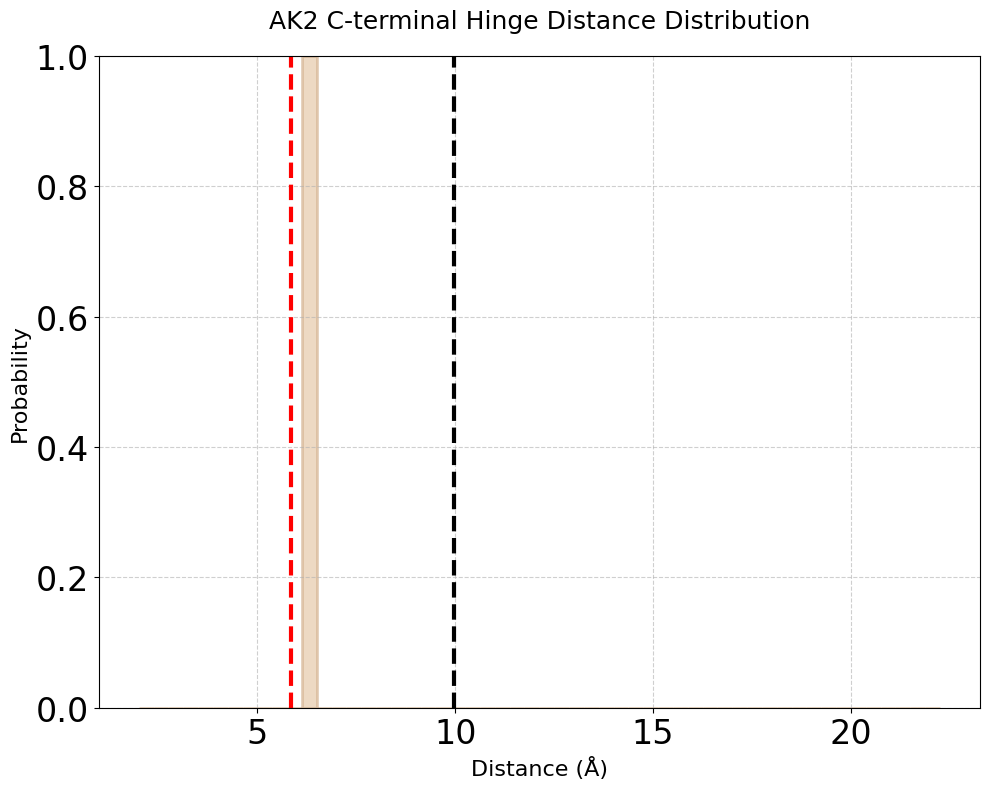

In [123]:
plot_distance_normalized_frequency(
    csv_file="/Users/busra/Documents/GitHub/AF-based_distograms/distogram_data/af3-seed25/ak2/measurements.csv",
    title="AK2 C-terminal Hinge Distance Distribution",
    color="#E1C09C",
    edgecolor="#D1AD89",
    output_filename="AF3-distance"
)